# Método Cadena Markov-Monte Carlo (MCMC)¶

In [1]:
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using Base.Threads: @threads,@spawn
using Plots
using PyCall
using DataFrames

## Funciones para construir el sistema $Ax = b$. Se debe usar un número entero par mayor que cero.



In [2]:

function matriz_vector_sist( n )
    M = Tridiagonal(-1*ones(n-1), 3*ones(n), -1*ones(n-1))
    M = M + zeros(n,n)
    for i = 1:n
        if i != n/2 && i != n/2 + 1
            M[i,n+1-i] = 0.5
        end
    end
    
    b = zeros(n)
    b[1] = 5/2
    b[n] = 5/2
    for i = 2:n-1
        if i == n/2 || i == n/2+1
            b[i] = 1
        else
            b[i] = 3/2
        end
    end
    
    return A,b
end

matriz_vector_sist (generic function with 1 method)

In [3]:
function matriz_vector_sistema(n)
    e = ones(n)
    n2 =Int(n/2)
    diags = [-1,0,1]
    A = Matrix(spdiagm(-1 => -ones(n-1)
        ,0 => 3*ones(n),1 => -ones(n-1)))
    c = spdiagm(0 => ones(n)/2)
    ab = [x for x=1:n]
    ba = [(n+1)-x for x=1:n]
    c = Matrix(permute(c, ba, ab))

    A = A + c
    A[n2+1,n2] = -1
    A[n2,n2+1] = -1
    
    b = zeros(n,1)
    b[1] = 2.5
    b[n] = 2.5
    b[2:n-1] .= [1.5]
    b[n2:n2+1] .= [1]
    return A,b
end

matriz_vector_sistema (generic function with 1 method)

In [4]:
n = 30
A, b = matriz_vector_sistema(n)
nA = norm(A);
typeof(A)

Matrix{Float64} (alias for Array{Float64, 2})

In [5]:
typeof(b)

Matrix{Float64} (alias for Array{Float64, 2})

## 1. Implementac MCMC con mejores práticas de Julia
A continuación se muestran diversas versiones del Método de Monte Carlo Cadenas de MArkov (MCMC) con la finalidad de evaluar la eficiencia y escalabilidad.

### a) MCMC con matriz de probabilidad in situ.
Esta primera versión del método crea las matrices auxiliares y posteriormente son utilizadas como variables globales. Adicionalmente, para elegir los elementos de T, f y P, Pi necesarios para construir las cadenas de Markov se hace una suma acumulada de probabilidades cada vez que se calcula un elemento de cada cadena.

In [6]:
M = diagm(0 => diag(A))
N = M-A
T = inv(M) * N
f = inv(M) * b
nT, mT = size(T);

In [7]:
S = fill(0, nT)
P = fill(0., nT, mT) 
[S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
[P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
Pi = [1/nT for i in 1:nT];

In [8]:
ϵ = 0.001
δ = 0.1 
Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1

130.0

In [9]:
function mcmcalg1(ϵ, Nc) 
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1
        for s in 1:Nc
            W = W_0; k = 0; point = i; X = W_0 * f[i]
            while abs(W) >= ϵ
                nextpoint  = 1
                u = rand()
                while u >= sum(P[point, 1:nextpoint])  #probabilidad acumulada in-situ
                    nextpoint = nextpoint + 1
                end
                k = k + 1
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint]) # T,P variables globales
                    X = X + W_new * f[nextpoint] # f variables globales
                point = nextpoint
                W = W_new
            end
        Xs[i] += X
        end
    end
    Xs = Xs/Nc
end

mcmcalg1 (generic function with 1 method)

In [10]:
TEalg1 = @benchmark mcmcalg1(ϵ, Nc) 

BenchmarkTools.Trial: 23 samples with 1 evaluation.
 Range (min … max):  202.569 ms … 294.817 ms  ┊ GC (min … max): 15.10% … 17.36%
 Time  (median):     215.561 ms               ┊ GC (median):    16.04%
 Time  (mean ± σ):   222.107 ms ±  21.760 ms  ┊ GC (mean ± σ):  16.48% ±  1.18%

  ▃ █▃▃   ▃                                                      
  █▁███▇▇▁█▇▁▇▇▁▁▁▇▁▇▁▁▁▇▁▁▁▇▇▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  203 ms           Histogram: frequency by time          295 ms <

 Memory estimate: 338.47 MiB, allocs estimate: 7507495.

### b) MCCM con matriz de probabilidad acumulada fuera del algoritmo, variable global
Se calcula la suma de probabilidad acumulada fuera del algoritmo mcmc. Continúa el uso de las matrices T, Pa, P y el vector f como variables globales.

In [11]:
M = diagm(0 => diag(A))
N = M-A
T = inv(M) * N
f = inv(M) * b
nT, mT = size(T);

In [12]:
S = fill(0, nT)
Pa = P = fill(0., nT, mT)
[S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
[P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
Pi = [1/nT for i in 1:nT];

In [13]:
function mcmcalg2(ϵ, Nc)
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        for s in 1:Nc
            W = W_0;  point = i; X = W_0 * f[i]
            while abs(W) >= ϵ
                nextpoint = 1
                u = rand()
                while u >= Pa[point][nextpoint]
                    nextpoint += 1
                end
                    W_new = W *(T[point, nextpoint]/P[point,nextpoint])
                    X += W_new * f[nextpoint]
                point = nextpoint
                W = W_new
            end
        Xs[i] += X
        end
    end
    Xs = Xs/Nc
end

mcmcalg2 (generic function with 1 method)

In [14]:
TEalg2 = @benchmark mcmcalg2(ϵ, Nc)

BenchmarkTools.Trial: 54 samples with 1 evaluation.
 Range (min … max):  91.607 ms … 105.819 ms  ┊ GC (min … max): 1.87% … 1.73%
 Time  (median):     93.585 ms               ┊ GC (median):    1.97%
 Time  (mean ± σ):   93.797 ms ±   2.260 ms  ┊ GC (mean ± σ):  2.75% ± 1.03%

   ▂ ▂▂▂    ▂▂    █   ▅▂▂                                       
  ▅█████▅▅█▅██▁▅▁▅█▅█▁████▅▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▁
  91.6 ms         Histogram: frequency by time         99.5 ms <

 Memory estimate: 64.98 MiB, allocs estimate: 4258161.

### c) MCCM con variables locales.
A continuación se envuelve en la función el cálculo de las matrices M,N,T y el vector f por lo que es necesrio enviar como argumentos de la función a la matriz A y el vector b.

In [15]:
function mcmcalg3(ϵ, δ, A, b) 
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT];
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
  
    Xs = fill(0., mT)

    for i in 1:mT
        W_0 = 1
        for s in 1:Nc
            W = W_0; k = 0; point = i; X = W_0 * f[i]
            while abs(W) >= ϵ
                nextpoint  = 1
                u = rand()
                while u >= Pa[point][nextpoint]
                    nextpoint = nextpoint + 1
                end
                k = k + 1
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])
                    X = X + W_new * f[nextpoint]
                point = nextpoint
                W = W_new
            end
        Xs[i] += X
        end
    end
    Xs = Xs/Nc
end

mcmcalg3 (generic function with 1 method)

In [16]:
TEalg3 = @benchmark mcmcalg3(ϵ, δ, A, b)

BenchmarkTools.Trial: 964 samples with 1 evaluation.
 Range (min … max):  4.444 ms …  20.797 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.095 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.184 ms ± 773.518 μs  ┊ GC (mean ± σ):  0.05% ± 1.04%

             ▃██▅▄▂                                            
  ▄▁▁▁▁▁▁▁▅▁▅███████▁▁▄▄▁▁▄▅▁▄▅▁▁▅▁▁▁▁▅▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▄▁▁▄ █
  4.44 ms      Histogram: log(frequency) by time      7.36 ms <

 Memory estimate: 66.97 KiB, allocs estimate: 83.

### d) MCCM con Matriz de probabilidad acumulada pre-build con envío de parámetros y type-anotations
Se usan variables locales, se envÍan como argumentos la matriz A y el vector b. Se calcula la matriz de probabilidad acumulada fuera del algoritmo mcmc y se usan anotaciones de tipos.

In [17]:
function mcmcalg4(ϵ::Float64, δ::Float64, A::Array{Float64,2}, b::Array{Float64,2})
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT]
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()::Float64
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmcalg4 (generic function with 1 method)

In [18]:
TEalg4 = @benchmark mcmcalg4(ϵ, δ, A, b)

BenchmarkTools.Trial: 996 samples with 1 evaluation.
 Range (min … max):  4.534 ms …  22.281 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.926 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.018 ms ± 869.657 μs  ┊ GC (mean ± σ):  0.05% ± 1.05%

        ▃█▆▂                                                   
  ▄▁▁▁▄▄████▇▆▄▄▁▁▁▁▁▁▁▅▄▄▄▁▁▁▁▄▁▁▁▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▇
  4.53 ms      Histogram: log(frequency) by time      7.53 ms <

 Memory estimate: 66.97 KiB, allocs estimate: 83.

## 2. Cálculo de tiempos de ejecución

2.02569282e8 || A). Probabilidad in situ
9.1606714e7 || B). Probabilidad acumulada fuera del algoritmo, variable global
4.444042e6 || C). Variables locales
4.533548e6 || D). Probabilidad acumulada pre-build con envío de parámetros y type-anotations


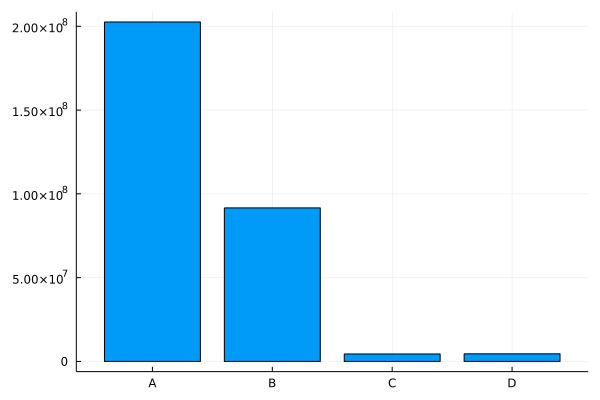

In [19]:
println(minimum(TEalg1).time," || A). Probabilidad in situ")
println(minimum(TEalg2).time," || B). Probabilidad acumulada fuera del algoritmo, variable global")
println(minimum(TEalg3).time," || C). Variables locales")
println(minimum(TEalg4).time," || D). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
using  DataFrames
arrMCMC= ["A","B","C","D"]
arrTime= [minimum(TEalg1).time,minimum(TEalg2).time,minimum(TEalg3).time,minimum(TEalg4).time]
bar(arrMCMC, arrTime,  label="")

## 3. Aumento de tamaño del Sitema de Ecuaciones Lineales Algebraico
Se varia el tamaño del Sistema de Ecuaiones Lineales Algebraico (SELA) y se cálculan los tiempos
a 10x10, 30x30, 50x50

### I. Cálculo de tiempos con Probabilidad in situ

In [20]:
arrTEalg1 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T);
    S = fill(0, nT)
    P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pi = [1/nT for i in 1:nT];
    ϵ = 0.001
    δ = 0.1 
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    TE1 = @benchmark mcmcalg1(ϵ, Nc) seconds=1
    push!(arrTEalg1, TE1)
end

6103050100

### II. Cálculo de tiempos con Probabilidad acumulada fuera del algoritmo, variable global

In [21]:
arrTEalg2 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T);
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT)
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT];
    TE2 = @benchmark mcmcalg2(ϵ, Nc) seconds=1
    push!(arrTEalg2, TE2)
end

6103050100

### III. Cálculo de timepos con Variables locales

In [22]:
arrTEalg3 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    ϵ = 0.001
    δ = 0.1 
    TE3 = @benchmark mcmcalg3(ϵ, δ, A, b) seconds=1
    push!(arrTEalg3, TE3)
end

6103050100

### IV. Cálculo de timepos con Type-anotations

In [23]:
arrTEalg4 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    ϵ = 0.001
    δ = 0.1 
    TE4 = @benchmark mcmcalg4(ϵ, δ, A, b) seconds=1
    push!(arrTEalg4, TE4)
end

6103050100

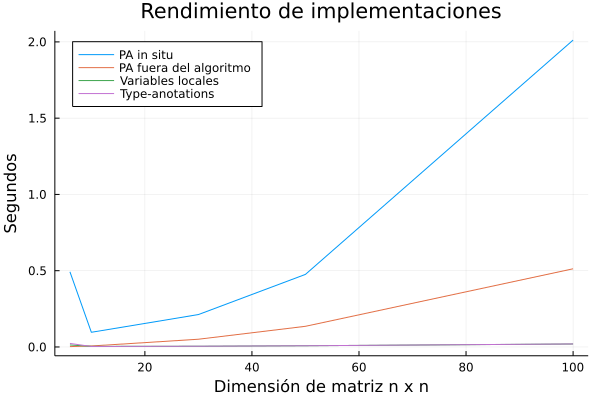

In [24]:
plot(title="Rendimiento de implementaciones", legend=:topleft, xaxis="Dimensión de matriz n x n", yaxis="Segundos")
plot!(mxn, [minimum(arrTEalg1[i]).time/10^9  for i=1:size(mxn)[1]], label="PA in situ")
plot!(mxn, [minimum(arrTEalg2[i]).time/10^9  for i=1:size(mxn)[1]], label="PA fuera del algoritmo")
plot!(mxn, [minimum(arrTEalg3[i]).time/10^9  for i=1:size(mxn)[1]], label="Variables locales")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="Type-anotations")


## 4. Implementación de SELA dispersos
Implementamos el uso de SparseArrays.jl para  optimizar la memoria en el Sistema de Ecuaiones Lineales Algebraico

In [25]:
function mcmcalg5(ϵ::Float64, δ::Float64, A::Array{Float64,2}, b::Array{Float64,2})
    
    A = dropzeros(sparse(A))
    b = dropzeros(sparse(b))
    
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT]
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        Threads.@threads for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()::Float64
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmcalg5 (generic function with 1 method)

In [26]:
TEalg5 = @benchmark mcmcalg5(ϵ, δ, A, b)

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  415.541 ms … 444.576 ms  ┊ GC (min … max): 2.13% … 1.93%
 Time  (median):     419.428 ms               ┊ GC (median):    1.81%
 Time  (mean ± σ):   422.985 ms ±   8.552 ms  ┊ GC (mean ± σ):  2.02% ± 0.40%

  ▁  ▁▁█ ▁▁ ▁    ▁        ▁              ▁                    ▁  
  █▁▁███▁██▁█▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  416 ms           Histogram: frequency by time          445 ms <

 Memory estimate: 166.84 MiB, allocs estimate: 10882158.

## 5. Implementación de estrategía de Cómputo de Alto Rendimiento
Se prueba la implementación de Threads simplificados para disminuir el tiempo de ejecución de MCMC

#### Número de hilos para la ejecucución

In [27]:
Threads.nthreads()=4
Threads.nthreads()

4

In [30]:
function mcmcalg6(ϵ::Float64, δ::Float64, A::Array{Float64,2}, b::Array{Float64,2})
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T)
    S = fill(0, nT)
    Pa = P = fill(0., nT, mT) 
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT]
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    
    Xs = fill(0., mT)
    for i in 1:mT
        W_0 = 1.0
        Threads.@threads for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()::Float64
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
    Xs = Xs/Nc::Float64
end

mcmcalg6 (generic function with 1 method)

In [31]:
TEalg6 = @benchmark mcmcalg6(ϵ, δ, A, b)

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  436.964 ms … 458.459 ms  ┊ GC (min … max): 1.70% … 1.69%
 Time  (median):     441.071 ms               ┊ GC (median):    1.76%
 Time  (mean ± σ):   442.904 ms ±   6.136 ms  ┊ GC (mean ± σ):  1.97% ± 0.41%

        ▃      █                                                 
  ▇▁▁▁▁▁█▇▁▇▇▁▁█▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  437 ms           Histogram: frequency by time          458 ms <

 Memory estimate: 166.46 MiB, allocs estimate: 10866084.

In [32]:
arrTEalg5 = []
arrTEalg6 = []
mxn = [6, 10, 30, 50, 100]

for n = mxn
    print(n)
    A,b = matriz_vector_sistema(n)
    ϵ = 0.001
    δ = 0.1 
    TE5 = @benchmark mcmcalg5(ϵ, δ, A, b) seconds=1
    TE6 = @benchmark mcmcalg6(ϵ, δ, A, b) seconds=1
    push!(arrTEalg5, TE5)
    push!(arrTEalg6, TE6)
end

6103050100

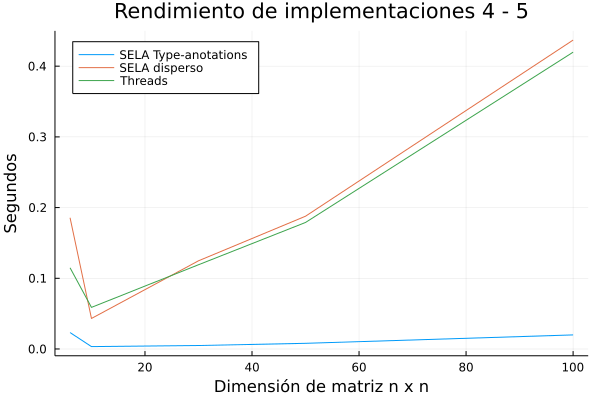

In [33]:
plot(title="Rendimiento de implementaciones 4 - 5", legend=:topleft, xaxis="Dimensión de matriz n x n", yaxis="Segundos")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="SELA Type-anotations")
plot!(mxn, [minimum(arrTEalg5[i]).time/10^9  for i=1:size(mxn)[1]], label="SELA disperso ")
plot!(mxn, [minimum(arrTEalg6[i]).time/10^9  for i=1:size(mxn)[1]], label="Threads")

In [34]:
TEalg4 = @benchmark mcmcalg4(ϵ, δ, A, b)

BenchmarkTools.Trial: 247 samples with 1 evaluation.
 Range (min … max):  19.595 ms … 35.400 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     20.052 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.255 ms ±  1.186 ms  ┊ GC (mean ± σ):  0.14% ± 1.15%

     ▆██▄▅▆▄                                                   
  ▄▁▇███████▄▁▄▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▄▁▁▁▁▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▆
  19.6 ms      Histogram: log(frequency) by time      24.5 ms <

 Memory estimate: 665.38 KiB, allocs estimate: 231.

2.02569282e8 || I). Probabilidad in situ
9.1606714e7 || II). Probabilidad acumulada fuera del algoritmo, variable global
4.444042e6 || III). Variables locales
1.9594666e7 || IV). Probabilidad acumulada pre-build con envío de parámetros y type-anotations
4.15540697e8 || V). Probabilidad acumulada pre-build con envío de parámetros y type-anotations
4.36963623e8 || VI). Probabilidad acumulada pre-build con envío de parámetros y type-anotations


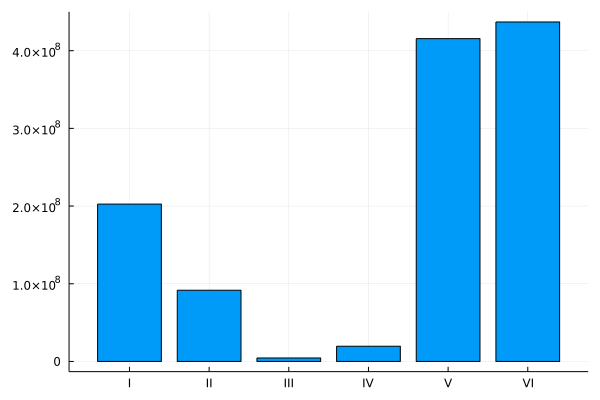

In [35]:
println(minimum(TEalg1).time," || I). Probabilidad in situ")
println(minimum(TEalg2).time," || II). Probabilidad acumulada fuera del algoritmo, variable global")
println(minimum(TEalg3).time," || III). Variables locales")
println(minimum(TEalg4).time," || IV). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
println(minimum(TEalg5).time," || V). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
println(minimum(TEalg6).time," || VI). Probabilidad acumulada pre-build con envío de parámetros y type-anotations")
using  DataFrames
arrMCMC= ["I","II","III","IV","V","VI"]
arrTime= [minimum(TEalg1).time,minimum(TEalg2).time,minimum(TEalg3).time,minimum(TEalg4).time,minimum(TEalg5).time,minimum(TEalg6).time]
bar(arrMCMC, arrTime,  label="")

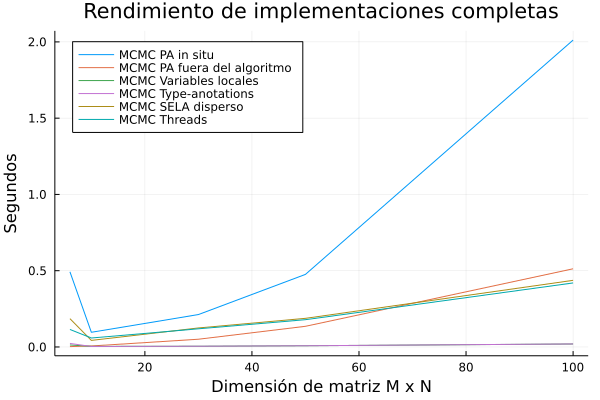

In [36]:
plot(title="Rendimiento de implementaciones completas", legend=:topleft, xaxis="Dimensión de matriz M x N", yaxis="Segundos")
plot!(mxn, [minimum(arrTEalg1[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA in situ")
plot!(mxn, [minimum(arrTEalg2[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA fuera del algoritmo")
plot!(mxn, [minimum(arrTEalg3[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Variables locales")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Type-anotations")
plot!(mxn, [minimum(arrTEalg5[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC SELA disperso ")
plot!(mxn, [minimum(arrTEalg6[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Threads")

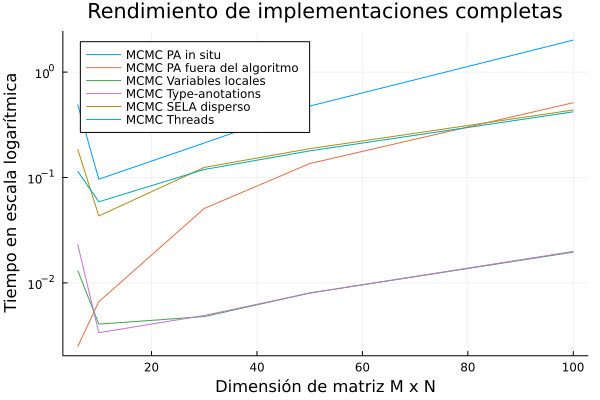

In [37]:
plot(title="Rendimiento de implementaciones completas", legend=:topleft, xaxis="Dimensión de matriz M x N", yaxis = ("Tiempo en escala logarítmica", :log))
plot!(mxn, [minimum(arrTEalg1[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA in situ")
plot!(mxn, [minimum(arrTEalg2[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC PA fuera del algoritmo")
plot!(mxn, [minimum(arrTEalg3[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Variables locales")
plot!(mxn, [minimum(arrTEalg4[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Type-anotations")
plot!(mxn, [minimum(arrTEalg5[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC SELA disperso ")
plot!(mxn, [minimum(arrTEalg6[i]).time/10^9  for i=1:size(mxn)[1]], label="MCMC Threads")